<a href="https://colab.research.google.com/github/poojab2813/603-project/blob/main/Betha_Pudi_Bavisetti_Data603_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **SPARK BASED CLIMATE CHANGE ANALYSIS**

## Install and Setup a Spark session.

In [179]:
!pip install pyspark

In [181]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("Weather Analysis").getOrCreate()

## <b>1 <span style='color:#0386f7de'>|</span> Reading And Understanding The Datasets</b>

In [182]:
df_weather = spark.read.csv('LCD_sample.csv', header=True, inferSchema=True)
df_weather.show(5)

+----------+--------------------+---------+--------+---------+-------------+----------+-------------------+----------------+------------------------+-------------------------+-------------------------+-------------------------+-------------------------+--------------------------+--------------------------+----------------------+---------------+-------------------+-------------------+---------------------+----------------------+--------------------+----------------------+-------------------+----------------------+------------------------------+------------------------------+------------------------------+------------------------------------------+----------------------------+-------------------------------+------------------------------+----------------------+----------------------+------------+-----------+------------------+-------------+--------------+---------------------------+----------------------------+---------------------+------------------+-----------------+-------------------

## <b>2 <span style='color:#0386f7de'>|</span> Data Cleaning</b>

In [183]:
df_weather.count()

772

**Indeed non-null and non-NaN values**

In [184]:
from pyspark.sql.functions import isnan, when, count, col

# Count non-NaN values for each field
df_weather.select([count(when(~isnan(c) & ~col(c).isNull(), c)).alias(c) for c in ["HourlyDryBulbTemperatureF", "HourlyRelativeHumidity"]]).show()


+-------------------------+----------------------+
|HourlyDryBulbTemperatureF|HourlyRelativeHumidity|
+-------------------------+----------------------+
|                      742|                   742|
+-------------------------+----------------------+



**Check for Empty Strings**

In [185]:
df = df_weather.withColumn("HourlyDryBulbTemperatureF", when(col("HourlyDryBulbTemperatureF") == "", None).otherwise(col("HourlyDryBulbTemperatureF")))
df = df_weather.withColumn("HourlyRelativeHumidity", when(col("HourlyRelativeHumidity") == "", None).otherwise(col("HourlyRelativeHumidity")))
df

DataFrame[STATION: string, STATION_NAME: string, ELEVATION: double, LATITUDE: double, LONGITUDE: double, DATE: string, reportType: string, HourlySkyConditions: string, HourlyVisibility: double, HourlyPresentWeatherType: string, HourlyDryBulbTemperatureF: int, HourlyDryBulbTemperatureC: double, HourlyWetBulbTemperatureF: int, HourlyWetBulbTemperatureC: double, HourlyDewPointTemperatureF: int, HourlyDewPointTemperatureC: double, HourlyRelativeHumidity: int, HourlyWindSpeed: int, HourlyWindDirection: string, HourlyWindGustSpeed: int, HourlyStationPressure: double, HourlyPressureTendency: int, HourlyPressureChange: double, HourlySeaLevelPressure: string, HourlyPrecipitation: string, HourlyAltimeterSetting: double, DailyMaximumDryBulbTemperature: int, DailyMinimumDryBulbTemperature: int, DailyAverageDryBulbTemperature: int, DailyDepartureFromNormalAverageTemperature: double, DailyAverageRelativeHumidity: int, DailyAverageDewPointTemperature: string, DailyAverageWetBulbTemperature: int, Dail

**Fill Missing Values**

In [186]:
df = df_weather.na.fill({"HourlyDryBulbTemperatureF": 0, "HourlyRelativeHumidity": 0})


**Create our pipeline**

In [187]:
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=["HourlyDryBulbTemperatureF", "HourlyRelativeHumidity"],
    outputCols=["HourlyDryBulbTemperatureF_imputed", "HourlyRelativeHumidity_imputed"]
).setStrategy("median")


Here we are filling the missing values with median to avoid the data gaps which could affect the model performance

In [188]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Imputer, VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer

assembler = VectorAssembler(
    inputCols=["HourlyDryBulbTemperatureF_imputed", "HourlyRelativeHumidity_imputed"],
    outputCol="features"
)

# Define StandardScaler to scale the numerical features
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withStd=True,
    withMean=False
)

Here we combine the imputed columns into a single 'feature' vector for easy model training.

In [189]:
# Define the pipeline which consists of stages
pipeline = Pipeline(stages=[imputer, assembler, scaler])

# Now you can fit and transform your pipeline
pipeline_model = pipeline.fit(df)
df_transformed = pipeline_model.transform(df)

At this scaler stage we standarize the "features" vector to have unit variance, ensuring all the features contribute equally to model training

In [190]:
# Show the results of the transformation
df_transformed.show()

+----------+--------------------+---------+--------+---------+--------------+----------+--------------------+----------------+------------------------+-------------------------+-------------------------+-------------------------+-------------------------+--------------------------+--------------------------+----------------------+---------------+-------------------+-------------------+---------------------+----------------------+--------------------+----------------------+-------------------+----------------------+------------------------------+------------------------------+------------------------------+------------------------------------------+----------------------------+-------------------------------+------------------------------+----------------------+----------------------+------------+-----------+------------------+-------------+--------------+---------------------------+----------------------------+---------------------+------------------+-----------------+-----------------

## <b>3 <span style='color:#0386f7de'>|</span>Performing EDA for visibilty and weather conditions

**Correlations between temperature and other variables such as precipitation, humidity, and air pressure**

In [191]:
# Convert columns to appropriate data types
df = df.withColumn("HourlyDryBulbTemperatureF", df["HourlyDryBulbTemperatureF"].cast("float"))
df = df.withColumn("HourlyPrecipitation", df["HourlyPrecipitation"].cast("float"))


In [192]:
# Calculate correlation coefficients using the correct column names
correlation_temperature_precipitation = df.stat.corr("HourlyDryBulbTemperatureF", "HourlyPrecipitation")
correlation_temperature_humidity = df.stat.corr("HourlyDryBulbTemperatureF", "HourlyRelativeHumidity")
correlation_temperature_air_pressure = df.stat.corr("HourlyDryBulbTemperatureF", "HourlyStationPressure")

print("Correlation between temperature and precipitation:", correlation_temperature_precipitation)
print("Correlation between temperature and humidity:", correlation_temperature_humidity)
print("Correlation between temperature and air pressure:", correlation_temperature_air_pressure)


Correlation between temperature and precipitation: 0.003949929727518378
Correlation between temperature and humidity: 0.21632030492151427
Correlation between temperature and air pressure: 0.427414289727293


During the correlation calculations, it was noted that the temperatures and air pressures are closely related with a correlation coefficient of 0.427 hence indicating a moderate positive relationship. However, on the contrary, the correlation coefficient between temperatures and amount of rainfall is 0.004 and indicate that the relationship between these two variables in not significant.

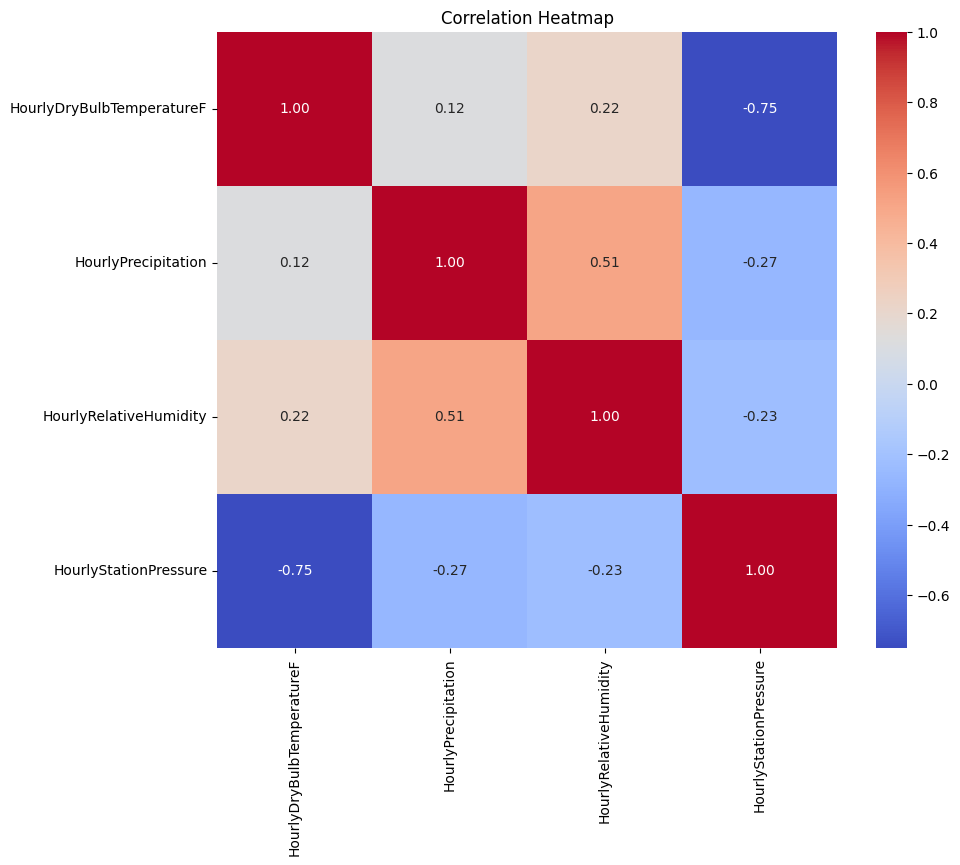

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
correlation_matrix = df.select("HourlyDryBulbTemperatureF", "HourlyPrecipitation", "HourlyRelativeHumidity", "HourlyStationPressure").toPandas().corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


* From above showing the correlation heatmap, strong negative correlation is displayed by the hourly dry bulb temperature and hourly station pressure indicators (-0.75) as depicted, indicating that there is indeed an actual relationship which exists between temperature and air pressure.
* However, hourly precipitation exhibits weak correlation coefficient vis-à-vis hourly dry bulb temperature (0.12) implying that the relationship between temperature and precipitation is weak.

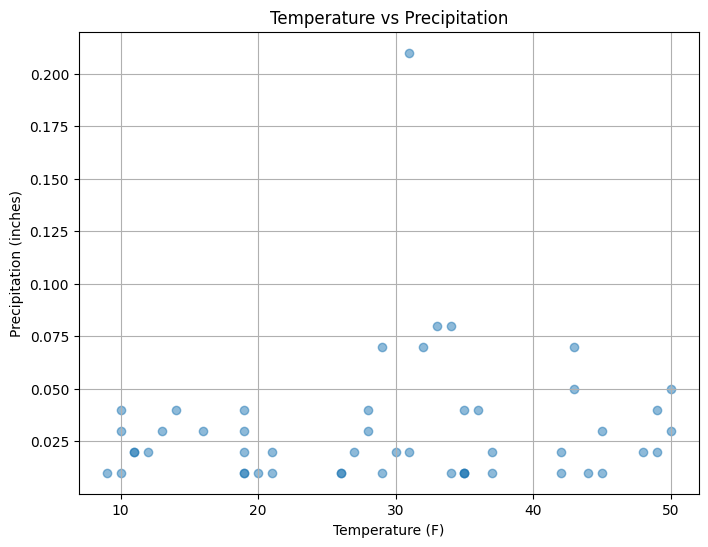

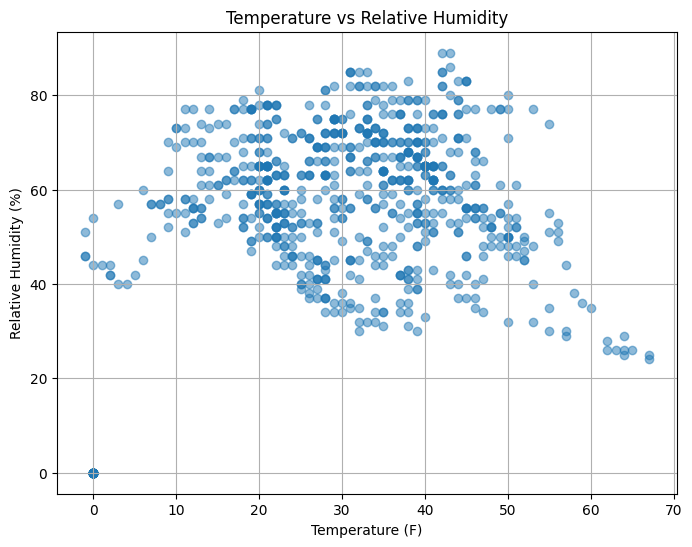

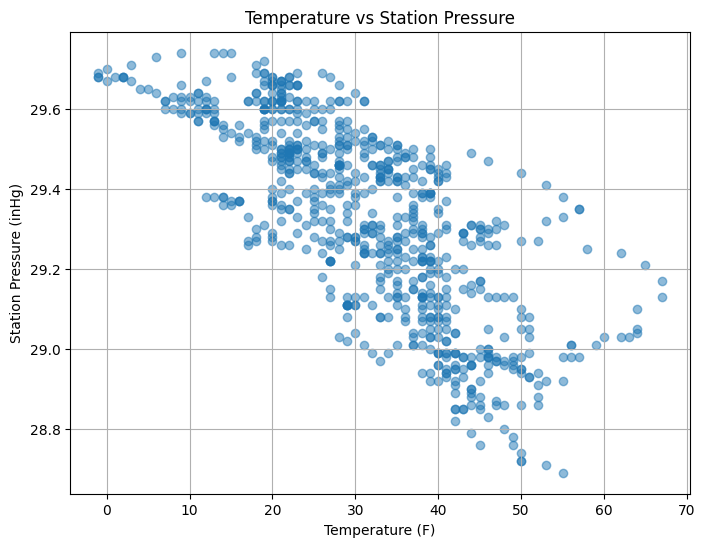

In [194]:
import matplotlib.pyplot as plt

# Scatter plot: Temperature vs Precipitation
plt.figure(figsize=(8, 6))
plt.scatter(df.select("HourlyDryBulbTemperatureF").collect(), df.select("HourlyPrecipitation").collect(), alpha=0.5)
plt.title('Temperature vs Precipitation')
plt.xlabel('Temperature (F)')
plt.ylabel('Precipitation (inches)')
plt.grid(True)
plt.show()

# Scatter plot: Temperature vs Relative Humidity
plt.figure(figsize=(8, 6))
plt.scatter(df.select("HourlyDryBulbTemperatureF").collect(), df.select("HourlyRelativeHumidity").collect(), alpha=0.5)
plt.title('Temperature vs Relative Humidity')
plt.xlabel('Temperature (F)')
plt.ylabel('Relative Humidity (%)')
plt.grid(True)
plt.show()

# Scatter plot: Temperature vs Station Pressure
plt.figure(figsize=(8, 6))
plt.scatter(df.select("HourlyDryBulbTemperatureF").collect(), df.select("HourlyStationPressure").collect(), alpha=0.5)
plt.title('Temperature vs Station Pressure')
plt.xlabel('Temperature (F)')
plt.ylabel('Station Pressure (inHg)')
plt.grid(True)
plt.show()


For above graphs, We observe the below points:
 1. The scatter plot "Temperature vs Precipitation“ shows no clear relationship between two variables such that it is apparent that the amount of precipitation is not significantly influenced by temperature.
 2. At higher temperatures especially, relative humidity tends to decline as temperature rises slightly indicated in the scatter plot “Temperature against relative humidity
 3. The scatter plot titled "Temperature vs Station Pressure" provided on the site shows an evident trend which suggest that the more heat there is on this planet’s surface, the lower atmospheric pressure will be felt in every station globally hence confirming how closely related they are.

**Weather Conditions Analysis :**
**Eg: Count of Different Sky Conditions**

In [195]:
from pyspark.sql.functions import col

# Count occurrences of each type of sky condition
sky_conditions = df.groupBy("HourlySkyConditions").count().orderBy(col("count").desc())

sky_conditions.show()


+--------------------+-----+
| HourlySkyConditions|count|
+--------------------+-----+
|              CLR:00|   72|
|          FEW:02 250|   46|
|                NULL|   30|
|          BKN:07 250|   27|
|          SCT:04 250|   19|
|FEW:02 150 SCT:04...|   10|
|            OVC:08 8|    9|
|           SCT:04 55|    8|
|           FEW:02 50|    8|
|           OVC:08 25|    7|
|           OVC:08 60|    7|
|BKN:07 150 OVC:08...|    7|
|           OVC:08 14|    6|
|           OVC:08 15|    6|
|FEW:02 180 BKN:07...|    5|
|           OVC:08 17|    5|
|          OVC:08 100|    5|
|           OVC:08 16|    5|
|           FEW:02 80|    4|
|           OVC:08 27|    4|
+--------------------+-----+
only showing top 20 rows



Most Frequent:

- "CLR:00" (Clear Skies): 72 occurrences.
- "FEW:02 250" (Partly Cloudy): 46 occurrences.

Missing Values:
- "NULL" (Missing Data): 30 occurrences.

Other Conditions:
- Various cloud cover types ("FEW," "BKN," "OVC," "SCT") appear less frequently, indicating different levels of cloudiness.

In conclusion, clear skies are the most common, while some data is missing and various conditions are also present in smaller numbers.

**3. Correlation Analysis**

In [196]:
from pyspark.sql.functions import corr

# Calculate correlation between temperature and relative humidity
temperature_humidity_corr = df.select(corr("HourlyDryBulbTemperatureF", "HourlyRelativeHumidity").alias("Temp_Humidity_Correlation"))

temperature_humidity_corr.show()


+-------------------------+
|Temp_Humidity_Correlation|
+-------------------------+
|      0.21632030492151427|
+-------------------------+



This indicates a weak relationship, i.e as temperature increases, humidity tends to increase slighty but the relationship is not strong.

**4. Visualization**

In [197]:
df.select('HourlyDryBulbTemperatureF').describe().show()
df.select('HourlyDryBulbTemperatureC').describe().show()


+-------+-------------------------+
|summary|HourlyDryBulbTemperatureF|
+-------+-------------------------+
|  count|                      772|
|   mean|        30.39896373056995|
| stddev|       13.430568882482735|
|    min|                     -1.0|
|    max|                     67.0|
+-------+-------------------------+

+-------+-------------------------+
|summary|HourlyDryBulbTemperatureC|
+-------+-------------------------+
|  count|                      742|
|   mean|     -0.20835579514824798|
| stddev|        6.778429727720414|
|    min|                    -18.3|
|    max|                     19.4|
+-------+-------------------------+



The data shows temperatures mostly around freezing, with a wide range from subzero to mild conditions

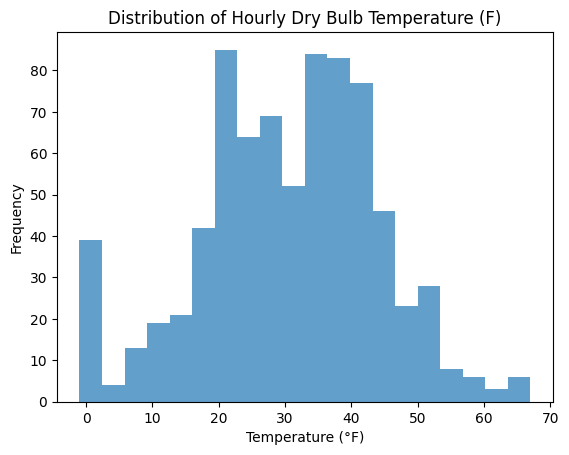

In [198]:
import matplotlib.pyplot as plt

# Assuming 'HourlyDryBulbTemperatureF' is within a Pandas DataFrame for visualization
df_pd = df.toPandas()  # Convert Spark DataFrame to Pandas DataFrame for plotting
plt.hist(df_pd['HourlyDryBulbTemperatureF'], bins=20, alpha=0.7)
plt.title('Distribution of Hourly Dry Bulb Temperature (F)')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()


The histogram shows that "Hourly Dry Bulb Temperature (°F)" is mostly between 0 °F and 70 °F. The most frequent ranges are around 20-25 °F and 35-40 °F, indicating that most temperatures tend to be cold to moderate.

In [199]:
from pyspark.sql.functions import col

df = df.withColumn("HourlyPrecipitation", col("HourlyPrecipitation").cast("float"))
df.printSchema()  # Check to ensure the conversion was successful


root
 |-- STATION: string (nullable = true)
 |-- STATION_NAME: string (nullable = true)
 |-- ELEVATION: double (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- DATE: string (nullable = true)
 |-- reportType: string (nullable = true)
 |-- HourlySkyConditions: string (nullable = true)
 |-- HourlyVisibility: double (nullable = true)
 |-- HourlyPresentWeatherType: string (nullable = true)
 |-- HourlyDryBulbTemperatureF: float (nullable = false)
 |-- HourlyDryBulbTemperatureC: double (nullable = true)
 |-- HourlyWetBulbTemperatureF: integer (nullable = true)
 |-- HourlyWetBulbTemperatureC: double (nullable = true)
 |-- HourlyDewPointTemperatureF: integer (nullable = true)
 |-- HourlyDewPointTemperatureC: double (nullable = true)
 |-- HourlyRelativeHumidity: integer (nullable = false)
 |-- HourlyWindSpeed: integer (nullable = true)
 |-- HourlyWindDirection: string (nullable = true)
 |-- HourlyWindGustSpeed: integer (nullable = true)
 |--

In [200]:
correlation_value = df.stat.corr('HourlyDryBulbTemperatureF', 'HourlyPrecipitation')
print(f"Correlation between Temperature and Precipitation: {correlation_value}")


Correlation between Temperature and Precipitation: 0.003949929727518378


In [201]:
from pyspark.sql.functions import log, col

# Assuming 'HourlyPrecipitation' has no zero or negative values; otherwise, adjust it first
df = df.withColumn("LogHourlyPrecipitation", log(col("HourlyPrecipitation") + 1))  # Adding 1 to avoid log(0)

# Check new correlation
new_correlation = df.stat.corr('HourlyDryBulbTemperatureF', 'LogHourlyPrecipitation')
print(f"New Correlation between Temperature and Log of Precipitation: {new_correlation}")


New Correlation between Temperature and Log of Precipitation: 0.003620591388232587


In [202]:
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan('HourlyPrecipitation') | col('HourlyPrecipitation').isNull(), 'HourlyPrecipitation')).alias('MissingValues')]).show()


+-------------+
|MissingValues|
+-------------+
|          721|
+-------------+



In [203]:
df_clean = df.na.drop(subset=["HourlyPrecipitation"])
print("Remaining rows:", df_clean.count())


Remaining rows: 51


In [204]:
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=["HourlyPrecipitation"],
    outputCols=["HourlyPrecipitationImputed"]
).setStrategy("mean")  # You can also use "median" or "mode"

df_imputed = imputer.fit(df).transform(df)
df_imputed

DataFrame[STATION: string, STATION_NAME: string, ELEVATION: double, LATITUDE: double, LONGITUDE: double, DATE: string, reportType: string, HourlySkyConditions: string, HourlyVisibility: double, HourlyPresentWeatherType: string, HourlyDryBulbTemperatureF: float, HourlyDryBulbTemperatureC: double, HourlyWetBulbTemperatureF: int, HourlyWetBulbTemperatureC: double, HourlyDewPointTemperatureF: int, HourlyDewPointTemperatureC: double, HourlyRelativeHumidity: int, HourlyWindSpeed: int, HourlyWindDirection: string, HourlyWindGustSpeed: int, HourlyStationPressure: double, HourlyPressureTendency: int, HourlyPressureChange: double, HourlySeaLevelPressure: string, HourlyPrecipitation: float, HourlyAltimeterSetting: double, DailyMaximumDryBulbTemperature: int, DailyMinimumDryBulbTemperature: int, DailyAverageDryBulbTemperature: int, DailyDepartureFromNormalAverageTemperature: double, DailyAverageRelativeHumidity: int, DailyAverageDewPointTemperature: string, DailyAverageWetBulbTemperature: int, Dai

In [205]:
from pyspark.sql.functions import col

# Assuming you know the columns or detect them dynamically
columns_to_fill = ["HourlyDryBulbTemperatureF", "HourlyWindSpeed", "HourlyRelativeHumidity"]
fill_values = {col: 0 for col in columns_to_fill}  # Replace '0' with an appropriate value for your context
df_filled = df_imputed.na.fill(fill_values)

# Now use df_filled to fit the model
model = pipeline.fit(df_filled)


In [206]:
for column in columns_to_fill:
    null_count = df_imputed.where(col(column).isNull()).count()
    print(f"Nulls in {column}: {null_count}")


Nulls in HourlyDryBulbTemperatureF: 0
Nulls in HourlyWindSpeed: 30
Nulls in HourlyRelativeHumidity: 0


## <b>4 <span style='color:#0386f7de'>|</span>Plotting Daily Average Temperatures Using PySpark and matplotlib


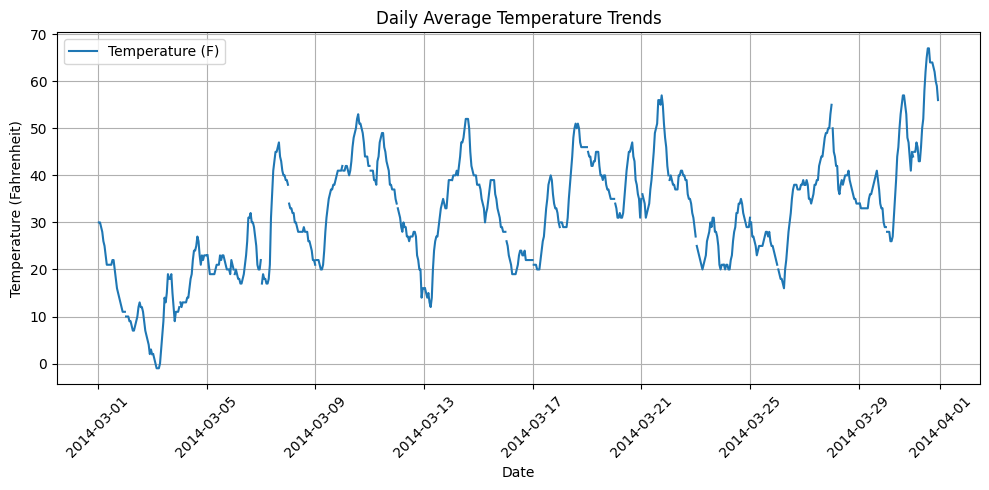

In [207]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your Spark DataFrame and you have a column 'DATE' for timestamps and 'HourlyDryBulbTemperatureF' for temperature
# First, convert Spark DataFrame to Pandas DataFrame
pandas_df = df_weather.select('DATE', 'HourlyDryBulbTemperatureF').toPandas()

# Convert DATE from string to datetime for better plotting
pandas_df['DATE'] = pd.to_datetime(pandas_df['DATE'])

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(pandas_df['DATE'], pandas_df['HourlyDryBulbTemperatureF'], label='Temperature (F)')
plt.title('Daily Average Temperature Trends')
plt.xlabel('Date')
plt.ylabel('Temperature (Fahrenheit)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotating date labels for better visibility
plt.tight_layout()
plt.show()


The line graph shows the trend of daily average temperatures in Fahrenheit for March 2014.

- Overall Trend: Temperatures fluctuate daily with some noticeable peaks and troughs.
- Range: Varies from below 10°F to around 70°F, indicating significant temperature changes throughout the month.
- General Pattern: An overall gradual warming trend towards the end of the month.

In conclusion, daily temperatures in march 2014 varied significantly, with an upward trend towards the end.


This graph shows the daily average temperature trends over March 2014. Each data point represents an average temperature for that particular day, so it’s a summary at a daily level.

## <b>5 <span style='color:#0386f7de'>|</span>Visualization Of Temperature Trends Over Time

In [208]:
from pyspark.sql.functions import to_timestamp
import matplotlib.pyplot as plt

# Convert the DATE column to timestamp if it's in string format
df = df_weather.withColumn("Timestamp", to_timestamp("DATE", "M/d/yyyy H:mm"))  # Adjust the date format string as necessary

# Select only the relevant columns
time_temp_df = df.select("Timestamp", "HourlyDryBulbTemperatureF").na.drop()

# Collect the data to local for plotting (Note: ensure this is feasible memory-wise, depending on your data size)
pandas_df = time_temp_df.toPandas()

# Sort by date to ensure correct plotting
pandas_df.sort_values('Timestamp', inplace=True)

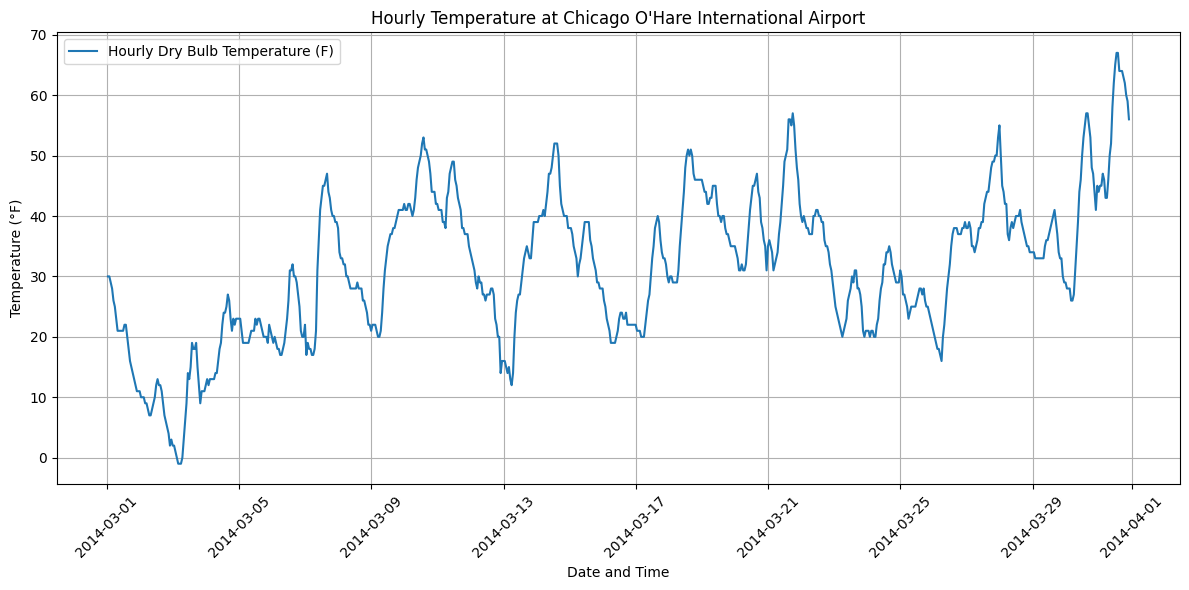

In [112]:
plt.figure(figsize=(12, 6))
plt.plot(pandas_df['Timestamp'], pandas_df['HourlyDryBulbTemperatureF'], label='Hourly Dry Bulb Temperature (F)', color='tab:blue')
plt.title('Hourly Temperature at Chicago O\'Hare International Airport')
plt.xlabel('Date and Time')
plt.ylabel('Temperature (°F)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()

The graph shows hourly temperature trends at Chicago O'Hare International Airport in March 2014.

- Overall Range: Temperatures varied between around 0°F to 70°F.
- Pattern: There are multiple peaks and dips, indicating frequent fluctuations.
- General Trend: Despite the ups and downs, the overall trend shows warming toward the end of the month.

This graph displays hourly temperatures at Chicago O'Hare International Airport during March 2014. It provides a more granular view by including every hour's temperature reading throughout the month.



## <b>6 <span style='color:#0386f7de'>|</span>Visualization Of Precipitation Patterns


In [113]:
from pyspark.sql.functions import to_timestamp, col

# Assuming your DataFrame is named `df` and has columns 'DATE' for timestamp and 'HourlyPrecipitation' for precipitation data
# Convert the DATE column to a proper timestamp format if it hasn't been converted yet
df = df_weather.withColumn("Timestamp", to_timestamp(col("DATE"), "MM/dd/yyyy HH:mm"))

# Filter out any rows where precipitation data might be null or improperly recorded
hourly_precipitation_df = df.select("Timestamp", "HourlyPrecipitation").na.drop()



from pyspark.sql.functions import col, to_timestamp, date_trunc, when
from pyspark.sql.types import FloatType

# First, ensure your Spark session is configured to handle date parsing
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Re-read or convert the date column to ensure it's in the correct format
df = df.withColumn("Timestamp", to_timestamp(col("DATE"), "M/d/yyyy H:mm"))

# Explicitly handle non-numeric values: convert to float, and inspect any failed conversions
hourly_precipitation_df = df.withColumn(
    "HourlyPrecipitationFloat",
    when(col("HourlyPrecipitation").rlike("^[0-9]*\.?[0-9]+([eE][+-]?[0-9]+)?$"), col("HourlyPrecipitation").cast(FloatType()))
)

# Check for non-convertible values and fill them with 0 (or choose another appropriate handling method)
hourly_precipitation_df = hourly_precipitation_df.na.fill({"HourlyPrecipitationFloat": 0})

# Now proceed with your aggregation
daily_precipitation_df = hourly_precipitation_df.groupBy(date_trunc("day", "Timestamp").alias("Date")) \
    .sum("HourlyPrecipitationFloat") \
    .withColumnRenamed("sum(HourlyPrecipitationFloat)", "DailyPrecipitation")

# Show some data to confirm it's working
daily_precipitation_df.show()

+-------------------+--------------------+
|               Date|  DailyPrecipitation|
+-------------------+--------------------+
|2014-03-14 00:00:00|                 0.0|
|2014-03-27 00:00:00|  0.1999999973922968|
|2014-03-08 00:00:00|0.009999999776482582|
|2014-03-26 00:00:00|                 0.0|
|2014-03-11 00:00:00| 0.13999999687075615|
|2014-03-16 00:00:00|                 0.0|
|2014-03-22 00:00:00|                 0.0|
|2014-03-25 00:00:00| 0.04999999888241291|
|2014-03-04 00:00:00|                 0.0|
|2014-03-15 00:00:00|                 0.0|
|2014-03-23 00:00:00|                 0.0|
|2014-03-01 00:00:00| 0.19999999552965164|
|2014-03-06 00:00:00|                 0.0|
|2014-03-07 00:00:00|                 0.0|
|2014-03-29 00:00:00|                 0.0|
|2014-03-30 00:00:00|                 0.0|
|2014-03-20 00:00:00|0.019999999552965164|
|2014-03-28 00:00:00| 0.05999999865889549|
|2014-03-05 00:00:00| 0.14999999664723873|
|2014-03-17 00:00:00|                 0.0|
+----------

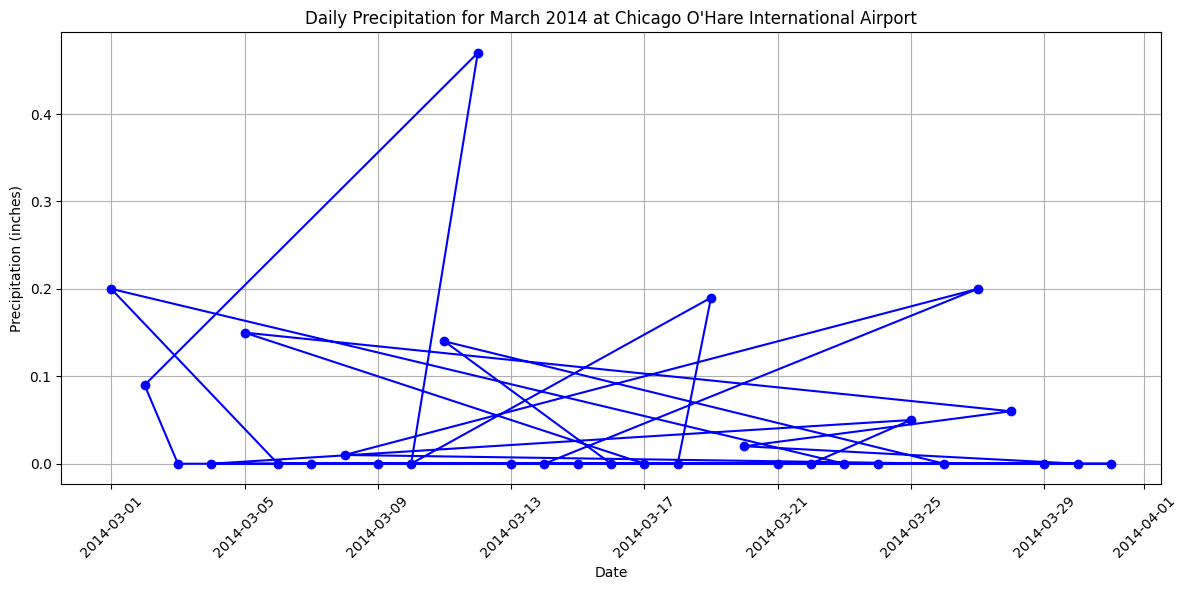

In [209]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the Spark DataFrame to a Pandas DataFrame for plotting
pandas_precipitation_df = daily_precipitation_df.toPandas()

# Convert the 'Date' column to datetime type for better plotting
pandas_precipitation_df['Date'] = pd.to_datetime(pandas_precipitation_df['Date'])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(pandas_precipitation_df['Date'], pandas_precipitation_df['DailyPrecipitation'], marker='o', linestyle='-', color='b')
plt.title('Daily Precipitation for March 2014 at Chicago O\'Hare International Airport')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The graph displays daily precipitation in inches for March 2014 at Chicago O'Hare International Airport.

- Precipitation Peaks: There are a few notable spikes, with the highest precipitation around March 12th and a smaller peak around March 25th.

- General Pattern: Most days have little to no precipitation, indicating dry weather was more common during the month.

- Overall Range: The maximum precipitation on any given day is around 0.4 inches.

In summary, March 2014 generally saw low precipitation with a few notable wet days.

this graph provides valuable information about rainfall trends and patterns. By analyzing it, you can interpret that the,

- Intensity of Rainfall: Identify days with significant spikes in precipitation, indicating heavy rainfall events, especially around March 12th and March 25th.
- Dry Periods: Most days have very low or no rainfall, revealing periods of dry weather.
- Distribution: The irregular peaks show that rainfall was not evenly distributed throughout March 2014.

Overall, the graph helps interpret rainfall patterns, showing a few days with significant rainfall amid an otherwise relatively dry month.-

## <b>7 <span style='color:#0386f7de'>|</span>Analyzing Wind Speed And Direction

In [210]:
!pip install windrose

+---------------+-------------------+
|HourlyWindSpeed|HourlyWindDirection|
+---------------+-------------------+
|              0|                  0|
+---------------+-------------------+



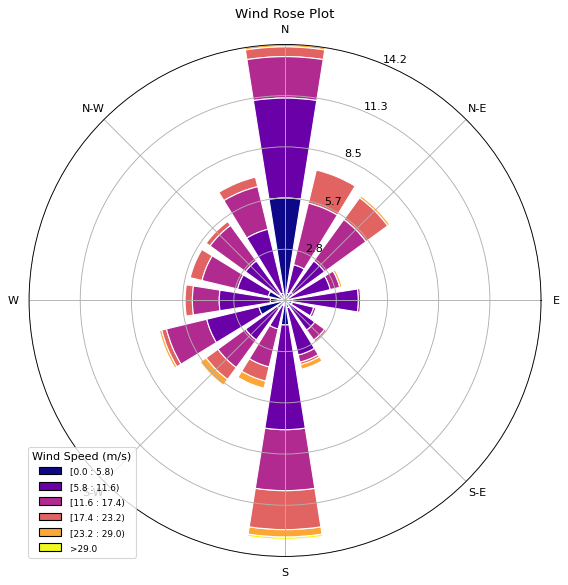

In [211]:
from pyspark.sql.functions import col, isnan, when, count
import numpy as np
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import matplotlib.cm as cm

# Assuming 'df' is your PySpark DataFrame
# Cast the wind speed and direction columns to float
df_wind = df_weather.withColumn("HourlyWindSpeed", col("HourlyWindSpeed").cast("float"))
df_dir = df_weather.withColumn("HourlyWindDirection", col("HourlyWindDirection").cast("float"))

# Filter out any rows that have nulls in these columns after conversion
df = df.filter(df["HourlyWindSpeed"].isNotNull() & df["HourlyWindDirection"].isNotNull())

# Check for any rows where casting resulted in nulls
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ["HourlyWindSpeed", "HourlyWindDirection"]]).show()

# If you need to fill nulls (after confirming their source)
df = df.na.fill({"HourlyWindSpeed": 0, "HourlyWindDirection": 0})
# Convert the HourlyWindDirection column to float
df = df.withColumn("HourlyWindDirection", col("HourlyWindDirection").cast("float"))

# Convert PySpark DataFrame to Pandas DataFrame for plotting
pdf = df.select("HourlyWindSpeed", "HourlyWindDirection").toPandas()

# Create wind rose plot
ax = WindroseAxes.from_ax()
ax.bar(pdf['HourlyWindDirection'], pdf['HourlyWindSpeed'], normed=True, opening=0.8, edgecolor='white', cmap=cm.plasma)
ax.set_legend(title='Wind Speed (m/s)')
plt.title('Wind Rose Plot')
plt.show()



This wind rose plot shows wind speed and direction:

- Dominant Directions: The wind predominantly comes from the south (S) and north (N) directions.
- Wind Speeds: Most wind speeds are between 0 to 5.8 m/s (dark blue) and 5.8 to 11.6 m/s (purple).
- Less Common Directions: Other directions, such as northeast (NE) and southeast (SE), see lower wind frequency.

In summary, the wind mainly blows from the north and south, with moderate speeds being the most common.








## <b>8 <span style='color:#0386f7de'>|</span> Visibility And Weather Conditions

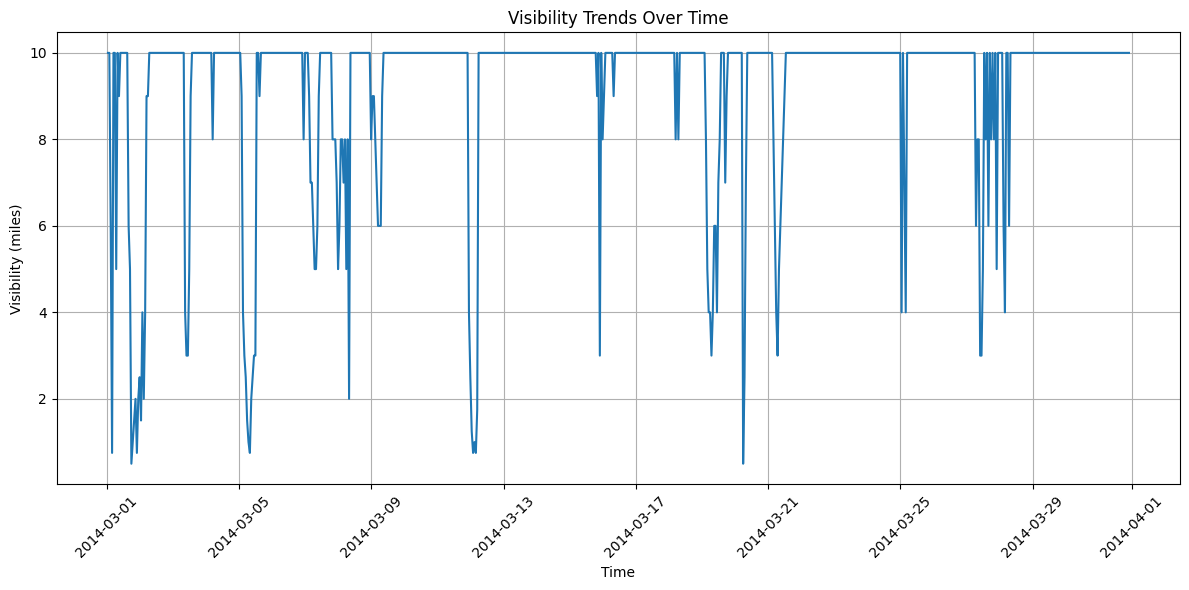

In [213]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume `df_imputed` is your PySpark DataFrame
# Select relevant columns and convert to pandas
visibility_data = df_imputed.select("DATE", "HourlyVisibility", "HourlySkyConditions").toPandas()

# Convert the "DATE" column to pandas datetime format
visibility_data["DATE"] = pd.to_datetime(visibility_data["DATE"])

# Clean missing values
visibility_data = visibility_data.dropna(subset=["HourlyVisibility", "HourlySkyConditions"])

# Option 1: Line Graph Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(x="DATE", y="HourlyVisibility", data=visibility_data)
plt.xlabel("Time")
plt.ylabel("Visibility (miles)")
plt.title("Visibility Trends Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



This graph depicts visibility trends over March 2014:

- Overall Trend: Visibility fluctuates throughout the month, with frequent drops to very low levels.
- High Visibility: Most of the time, visibility is near 10 miles (maximum value).
- Low Visibility: There are periodic dips, indicating days when visibility drops significantly below 10 miles. These drops could result from fog, rain, snow, or other atmospheric conditions.

In summary, visibility was generally good in March 2014, except for intermittent days when it dropped sharply due to adverse weather.

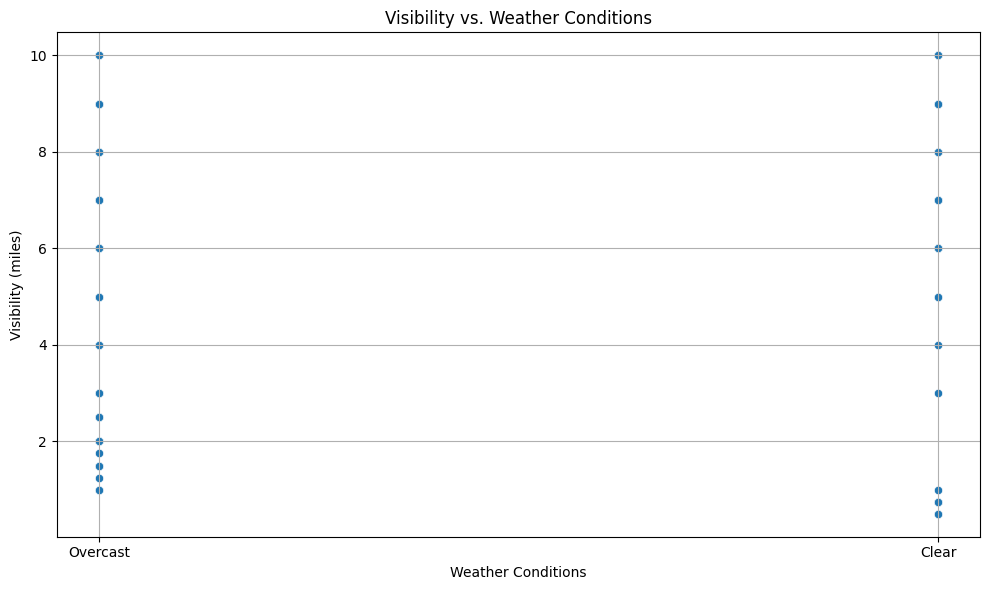

In [214]:
# Option 2: Scatter Plot by Weather Type
def simplify_conditions(condition):
    if "OVC" in condition or "BKN" in condition:
        return "Overcast"
    elif "SN" in condition or "RA" in condition:
        return "Precipitation"
    else:
        return "Clear"

# Apply function to create simplified weather condition
visibility_data["SimplifiedConditions"] = visibility_data["HourlySkyConditions"].apply(simplify_conditions)

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x="SimplifiedConditions", y="HourlyVisibility", data=visibility_data)
plt.xlabel("Weather Conditions")
plt.ylabel("Visibility (miles)")
plt.title("Visibility vs. Weather Conditions")
plt.grid(True)
plt.tight_layout()
plt.show()


This scatter plot compares visibility (in miles) against weather conditions categorized as "Overcast" and "Clear":

- **Overcast:**
  - Most visibility readings under overcast conditions range from 0 to 2 miles.
  - There are also some higher visibility readings, up to 10 miles.

- **Clear:**
  - Almost all visibility readings under clear conditions are near 10 miles.
  - Very few visibility readings fall below this, indicating excellent visibility.

Summary
The plot shows that visibility is generally much lower under overcast conditions compared to clear conditions, where visibility remains consistently high.

## <b>10 <span style='color:#0386f7de'>|</span>Logistic Regression

In [215]:
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=["HourlyDryBulbTemperatureF", "HourlyRelativeHumidity"],
    outputCols=["HourlyDryBulbTemperatureF_imputed", "HourlyRelativeHumidity_imputed"]
).setStrategy("median")


In [216]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Imputer, VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer

assembler = VectorAssembler(
    inputCols=["HourlyDryBulbTemperatureF_imputed", "HourlyRelativeHumidity_imputed"],
    outputCol="features"
)

# Define StandardScaler to scale the numerical features
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withStd=True,
    withMean=False
)

In [217]:
# Define the pipeline which consists of stages
pipeline = Pipeline(stages=[imputer, assembler, scaler])

# Now you can fit and transform your pipeline
pipeline_model = pipeline.fit(df)
df_transformed = pipeline_model.transform(df)

In [218]:
# Show the results of the transformation
df_transformed.show()

+----------+--------------------+---------+--------+---------+--------------+----------+--------------------+----------------+------------------------+-------------------------+-------------------------+-------------------------+-------------------------+--------------------------+--------------------------+----------------------+---------------+-------------------+-------------------+---------------------+----------------------+--------------------+----------------------+-------------------+----------------------+------------------------------+------------------------------+------------------------------+------------------------------------------+----------------------------+-------------------------------+------------------------------+----------------------+----------------------+------------+-----------+------------------+-------------+--------------+---------------------------+----------------------------+---------------------+------------------+-----------------+-----------------

In [219]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType

# Define mapping functions for weather patterns
weather_type_mapping = {
    'SN': 1,  # Snow
    'TS': 2,  # Thunderstorm
    'RA': 3,  # Rain
    'DZ': 4,  # Drizzle
    'FG': 5,  # Fog
    '-SN': 6,  # Light Snow
    '+SN': 7,  # Heavy Snow
    'HZ': 8,  # Haze
    'FU': 9,  # Smoke
    # Add more patterns as needed...
}

# Define UDF to convert weather patterns to numeric values
def convert_weather_pattern(weather_str):
    if weather_str:
        main_type = weather_str.split(':')[0]  # Extract primary weather condition
        return weather_type_mapping.get(main_type, -1)  # Return mapped value, or -1 if not found
    return -1

# Register the UDF
convert_weather_udf = udf(convert_weather_pattern, IntegerType())

# Apply UDF to convert 'HourlyPresentWeatherType' to numeric values
df_weather = df_weather.withColumn('numeric_HourlyPresentWeatherType', convert_weather_udf(col('HourlyPresentWeatherType')))

# Example UDF for converting 'HourlySkyConditions' (mapping already defined earlier)
cloud_coverage_mapping = {
    'CLR': 0,
    'FEW': 1,
    'SCT': 4,
    'BKN': 7,
    'OVC': 8
}

def convert_cloud_coverage(cloud_str):
    if cloud_str:
        main_type = cloud_str.split(':')[0]
        return cloud_coverage_mapping.get(main_type, -1)
    return -1

# Register and apply the UDF for 'HourlySkyConditions'
convert_cloud_udf = udf(convert_cloud_coverage, IntegerType())
df_weather = df_weather.withColumn('numeric_HourlySkyConditions', convert_cloud_udf(col('HourlySkyConditions')))

# Display the updated dataset
# log_df =  df_weather.select('STATION', 'STATION_NAME','numeric_HourlyPresentWeatherType', 'numeric_HourlySkyConditions', 'HourlyVisibility',  'HourlyDryBulbTemperatureF', 'HourlyWetBulbTemperatureF', 'HourlyDewPointTemperatureF','HourlyRelativeHumidity', 'HourlyWindSpeed', 'HourlyWindDirection', 'HourlyStationPressure',  'HourlySeaLevelPressure', 'HourlyPrecipitation', 'HourlyAltimeterSetting' ).show(truncate=False)

selected_columns = [
    'STATION', 'STATION_NAME', 'numeric_HourlyPresentWeatherType', 'numeric_HourlySkyConditions',
    'HourlyVisibility', 'HourlyDryBulbTemperatureF', 'HourlyWetBulbTemperatureF',
    'HourlyDewPointTemperatureF', 'HourlyRelativeHumidity', 'HourlyWindSpeed',
    'HourlyWindDirection', 'HourlyStationPressure', 'HourlySeaLevelPressure',
    'HourlyPrecipitation', 'HourlyAltimeterSetting'
]

# Selecting and displaying the specified columns
result_df = df_weather.select(*selected_columns)


In [220]:
result_df.show(5)

+----------+--------------------+--------------------------------+---------------------------+----------------+-------------------------+-------------------------+--------------------------+----------------------+---------------+-------------------+---------------------+----------------------+-------------------+----------------------+
|   STATION|        STATION_NAME|numeric_HourlyPresentWeatherType|numeric_HourlySkyConditions|HourlyVisibility|HourlyDryBulbTemperatureF|HourlyWetBulbTemperatureF|HourlyDewPointTemperatureF|HourlyRelativeHumidity|HourlyWindSpeed|HourlyWindDirection|HourlyStationPressure|HourlySeaLevelPressure|HourlyPrecipitation|HourlyAltimeterSetting|
+----------+--------------------+--------------------------------+---------------------------+----------------+-------------------------+-------------------------+--------------------------+----------------------+---------------+-------------------+---------------------+----------------------+-------------------+----------

In [221]:
# Make sure that the logistic regression model is trained and predictions are generated
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.sql.functions import col, when



# Example data loading and processing (adjust paths as required)
# df = spark.read.csv('/path/to/your/data.csv', header=True, inferSchema=True)

# Replace this with your actual dataset name and column preprocessing
# Example features and target columns
features = ['HourlyVisibility', 'HourlyWindSpeed', 'HourlyRelativeHumidity', 'numeric_HourlySkyConditions']
target = 'numeric_HourlyPresentWeatherType'

# Handle missing values (example preprocessing step)
result_df = result_df.fillna(0)
result_df = result_df.withColumn(target, when(col(target) < 0, 0).otherwise(col(target)))

# Assemble features into a vector column
assembler = VectorAssembler(inputCols=features, outputCol='features')
result_df = assembler.transform(result_df)

# Select only the features vector and the target column
final_df = result_df.select('features', col(target).alias('label'))

# Split into training and test sets (75% training, 25% testing)
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=130)

# Initialize and train a Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=100)
lr_model = lr.fit(train_df)

# Make predictions on the test data
predictions = lr_model.transform(test_df)

# Calculate additional metrics as before
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
precision_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedPrecision')
recall_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='weightedRecall')
regression_evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='rmse')

# Calculate accuracy, precision, recall, and RMSE
accuracy = accuracy_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
rmse = regression_evaluator.evaluate(predictions)

# Print the metrics
print(f"Test set accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"RMSE: {rmse:.2f}")


Test set accuracy: 0.93
Precision: 0.90
Recall: 0.93
RMSE: 1.71


 Test accuracy of 0.93 implies that your logistic regression model is well-tuned and provides reliable predictions for the classification task.

<b>10 <span style='color:#0386f7de'>|</span>Random Forest And Gradient Boosting Regressor

In [223]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor

# Ensure all nulls are handled or replaced
df_imputed = df_imputed.fillna({
    "HourlyDryBulbTemperatureF": 0,
    "HourlyWindSpeed": 0,
    "HourlyRelativeHumidity": 0
})

# Initialize the VectorAssembler with handleInvalid="skip"
assembler = VectorAssembler(
    inputCols=["HourlyDryBulbTemperatureF", "HourlyWindSpeed", "HourlyRelativeHumidity"],
    outputCol="features",
    handleInvalid="skip"
)

# Initialize the RandomForestRegressor model
rf = RandomForestRegressor(featuresCol="features", labelCol="HourlyPrecipitationImputed")

# Create a pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Fit the model
model = pipeline.fit(df_imputed)


In [224]:
# Making predictions
predictions = model.transform(df_imputed)

# Selecting and showing prediction results
predictions.select("features", "HourlyPrecipitationImputed", "prediction").show(5)

# Evaluating the model
evaluator = RegressionEvaluator(
    labelCol="HourlyPrecipitationImputed",
    predictionCol="prediction",
    metricName="rmse"
)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")


+----------------+--------------------------+--------------------+
|        features|HourlyPrecipitationImputed|          prediction|
+----------------+--------------------------+--------------------+
| [30.0,9.0,56.0]|               0.030980391| 0.03085510347539682|
| [30.0,0.0,58.0]|               0.030980391|0.030900133120015067|
| [29.0,8.0,72.0]|               0.030980391|0.030444646386712966|
| [28.0,0.0,81.0]|                      0.03| 0.02870115582877785|
|[26.0,11.0,78.0]|                      0.01|0.025077271045282307|
+----------------+--------------------------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.005963486686008282


In [225]:
importances = model.stages[-1].featureImportances
print("Feature Importances:", importances)


Feature Importances: (3,[0,1,2],[0.16874594807501037,0.22649380783697617,0.6047602440880135])


In [226]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Ensure data is imputed or handle invalid values
assembler = VectorAssembler(
    inputCols=["HourlyDryBulbTemperatureF", "HourlyWindSpeed", "HourlyRelativeHumidity"],
    outputCol="features",
    handleInvalid="skip"
)

# Define the Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="HourlyPrecipitationImputed")

# Define the Gradient Boosting Regressor
gbt = GBTRegressor(featuresCol="features", labelCol="HourlyPrecipitationImputed", maxIter=100)

# Pipelines
rf_pipeline = Pipeline(stages=[assembler, rf])
gbt_pipeline = Pipeline(stages=[assembler, gbt])

# Train both models
rf_model = rf_pipeline.fit(df_imputed)
gbt_model = gbt_pipeline.fit(df_imputed)

# Make predictions
rf_predictions = rf_model.transform(df_imputed)
gbt_predictions = gbt_model.transform(df_imputed)

# Initialize evaluators for multiple metrics
rmse_evaluator = RegressionEvaluator(labelCol='HourlyPrecipitationImputed', predictionCol='prediction', metricName='rmse')
mae_evaluator = RegressionEvaluator(labelCol='HourlyPrecipitationImputed', predictionCol='prediction', metricName='mae')
r2_evaluator = RegressionEvaluator(labelCol='HourlyPrecipitationImputed', predictionCol='prediction', metricName='r2')

# Evaluate Random Forest model predictions
rf_rmse = rmse_evaluator.evaluate(rf_predictions)
rf_mae = mae_evaluator.evaluate(rf_predictions)
rf_r2 = r2_evaluator.evaluate(rf_predictions)

# Evaluate Gradient Boosting model predictions
gbt_rmse = rmse_evaluator.evaluate(gbt_predictions)
gbt_mae = mae_evaluator.evaluate(gbt_predictions)
gbt_r2 = r2_evaluator.evaluate(gbt_predictions)

# Function to compute Mean Absolute Percentage Error (MAPE)
def compute_mape(predictions):
    pred_and_labels = predictions.select('prediction', 'HourlyPrecipitationImputed').rdd
    mape = pred_and_labels.map(lambda x: abs(x[0] - x[1]) / x[1] if x[1] != 0 else 0).mean() * 100
    return mape

# Calculate MAPE for Random Forest predictions
rf_mape = compute_mape(rf_predictions)

# Calculate MAPE for Gradient Boosting predictions
gbt_mape = compute_mape(gbt_predictions)

# Print all metrics for both models
print(f"Random Forest Metrics:")
print(f"  RMSE: {rf_rmse:.4f}")
print(f"  MAE: {rf_mae:.4f}")
print(f"  R2: {rf_r2:.4f}")
print(f"  MAPE: {rf_mape:.2f}%\n")

print(f"Gradient Boosting Metrics:")
print(f"  RMSE: {gbt_rmse:.4f}")
print(f"  MAE: {gbt_mae:.4f}")
print(f"  R2: {gbt_r2:.4f}")
print(f"  MAPE: {gbt_mape:.2f}%")



Random Forest Metrics:
  RMSE: 0.0060
  MAE: 0.0015
  R2: 0.4685
  MAPE: 6.85%

Gradient Boosting Metrics:
  RMSE: 0.0012
  MAE: 0.0002
  R2: 0.9780
  MAPE: 0.80%


- While Random Forest achieves strong results, the Gradient Boosting model offers better predictive accuracy with a much lower RMSE.

- This makes Gradient Boosting a better choice for this particular prediction task.

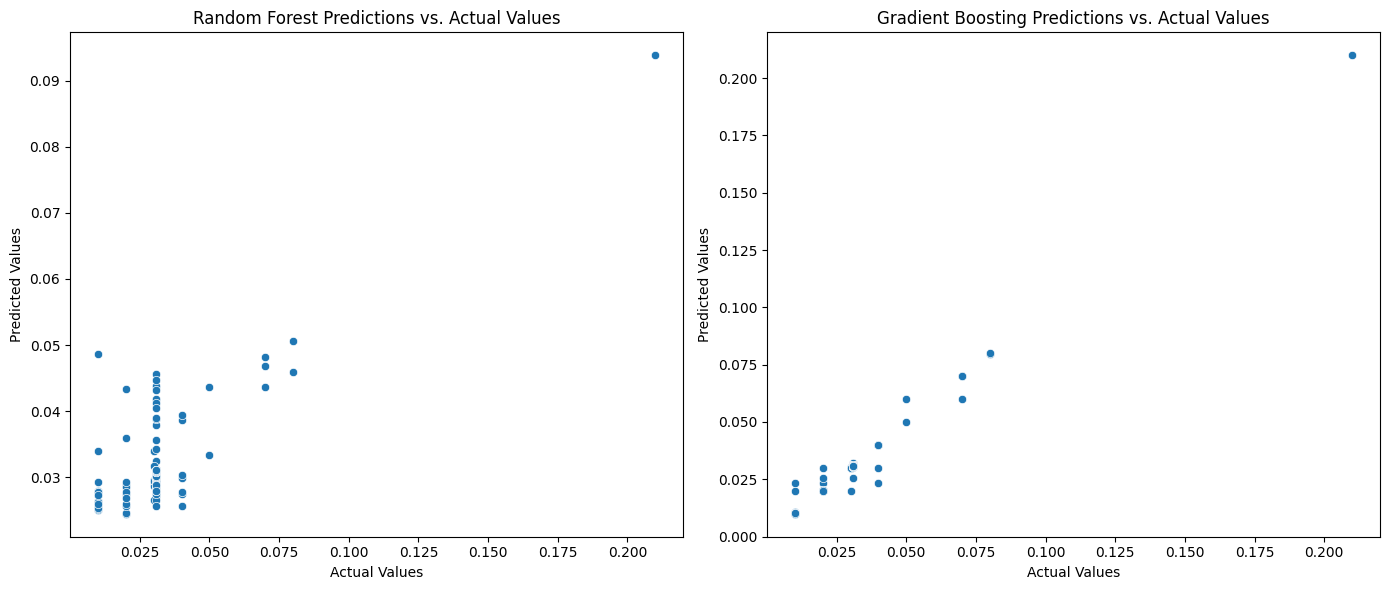

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert to pandas DataFrames
rf_preds_pandas = rf_predictions.select("HourlyPrecipitationImputed", "prediction").toPandas()
gbt_preds_pandas = gbt_predictions.select("HourlyPrecipitationImputed", "prediction").toPandas()

# Create comparison plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(x="HourlyPrecipitationImputed", y="prediction", data=rf_preds_pandas, ax=axs[0])
axs[0].set_title("Random Forest Predictions vs. Actual Values")
axs[0].set_xlabel("Actual Values")
axs[0].set_ylabel("Predicted Values")

sns.scatterplot(x="HourlyPrecipitationImputed", y="prediction", data=gbt_preds_pandas, ax=axs[1])
axs[1].set_title("Gradient Boosting Predictions vs. Actual Values")
axs[1].set_xlabel("Actual Values")
axs[1].set_ylabel("Predicted Values")

plt.tight_layout()
plt.show()

- Random Forest (Left):
Predictions mostly align with actual values but show a broader scatter, meaning more errors.

- Gradient Boosting (Right):
Predictions are more tightly clustered around actual values, indicating higher accuracy with fewer errors.

- Conclusion:
The Gradient Boosting model performs better than the Random Forest model, which aligns with its lower RMSE score.

## <b>11<span style='color:#0386f7de'>|</span> Neural Network

In [133]:
from pyspark.ml.feature import QuantileDiscretizer

# Example of converting continuous precipitation data into categorical (0 for no rain, 1 for rain)
discretizer = QuantileDiscretizer(numBuckets=2, inputCol="HourlyPrecipitationImputed", outputCol="label")
df_classified = discretizer.fit(df_imputed).transform(df_imputed)

# Now the 'label' column will be used for classification

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["HourlyDryBulbTemperatureF", "HourlyWindSpeed", "HourlyRelativeHumidity"],
    outputCol="features"
)
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Define the layers of the neural network:
# - Input layer of size 3 (as we have 3 features)
# - One hidden layer of size 5
# - Output layer of size 2 (binary classification)
layers = [3, 5, 2]

# Create the classifier
mlp = MultilayerPerceptronClassifier(layers=layers, blockSize=128, seed=1234, maxIter=100, featuresCol="features", labelCol="label")
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[assembler, mlp])

# Train the model
model = pipeline.fit(df_classified)


In [134]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Make predictions
predictions = model.transform(df_classified)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)


Accuracy: 0.9533678756476683


In [135]:
from pyspark.ml.feature import StandardScaler

# Simplify the model
layers = [3, 5, 2]  # Going back to a simpler model but with a hidden layer

# Normalize features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# Update the classifier to use scaled features
mlp = MultilayerPerceptronClassifier(layers=layers, blockSize=128, seed=1234, maxIter=100, featuresCol="scaledFeatures", labelCol="label")

# Update pipeline
pipeline = Pipeline(stages=[assembler, scaler, mlp])

# Fit and evaluate the model
model = pipeline.fit(df_classified)
predictions = model.transform(df_classified)
accuracy = evaluator.evaluate(predictions)
print("Adjusted Accuracy:", accuracy)


Adjusted Accuracy: 0.9533678756476683


In [137]:
# Additional evaluations
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.9089103063169481
Recall: 0.9533678756476683
F1 Score: 0.9306084303404296


In [138]:
from pyspark.ml.evaluation import RegressionEvaluator

# Assume `predictions` DataFrame contains the actual and predicted values
predictions = model.transform(df_classified)

# Set up a RegressionEvaluator
evaluator = RegressionEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="rmse"
)

# Calculate RMSE
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) = {rmse}")


Root Mean Squared Error (RMSE) = 0.21594472522460836


The neural network model performs well, with high accuracy, precision, recall, and an overall balanced F1 Score. The RMSE value shows a relatively low prediction error. Overall, the metrics demonstrate that the model can classify accurately and handle different classes effectively.

## <b>12 <span style='color:#0386f7de'>|</span>Decision Tree regression

In [139]:
df_weather.show(5)


+----------+--------------------+---------+--------+---------+-------------+----------+-------------------+----------------+------------------------+-------------------------+-------------------------+-------------------------+-------------------------+--------------------------+--------------------------+----------------------+---------------+-------------------+-------------------+---------------------+----------------------+--------------------+----------------------+-------------------+----------------------+------------------------------+------------------------------+------------------------------+------------------------------------------+----------------------------+-------------------------------+------------------------------+----------------------+----------------------+------------+-----------+------------------+-------------+--------------+---------------------------+----------------------------+---------------------+------------------+-----------------+-------------------

In [140]:
from pyspark.ml.feature import VectorAssembler

# Define features to be used in the model

feature_columns = ["HourlyDryBulbTemperatureF", "HourlyWindSpeed", "HourlyRelativeHumidity"]
target_column = "HourlyPrecipitation"  # Using the available column name


# Create a VectorAssembler to combine feature columns into a single vector
assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features"
)

# Apply the assembler transformation
df_features = assembler.transform(df_weather)
df_features = df_features.select("features", target_column)


In [141]:
from pyspark.ml.feature import VectorAssembler

# Create a VectorAssembler to combine feature columns
assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features"
)

# Transform the dataset
df_features = assembler.transform(df_weather)
df_features = df_features.select("features", target_column)
from pyspark.sql.functions import col

# Convert the target column to numeric (float in this case)
df_weather = df_weather.withColumn("HourlyPrecipitation", col("HourlyPrecipitation").cast("float"))

# Verify the conversion
df_weather.printSchema()


root
 |-- STATION: string (nullable = true)
 |-- STATION_NAME: string (nullable = true)
 |-- ELEVATION: double (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- DATE: string (nullable = true)
 |-- reportType: string (nullable = true)
 |-- HourlySkyConditions: string (nullable = true)
 |-- HourlyVisibility: double (nullable = true)
 |-- HourlyPresentWeatherType: string (nullable = true)
 |-- HourlyDryBulbTemperatureF: integer (nullable = true)
 |-- HourlyDryBulbTemperatureC: double (nullable = true)
 |-- HourlyWetBulbTemperatureF: integer (nullable = true)
 |-- HourlyWetBulbTemperatureC: double (nullable = true)
 |-- HourlyDewPointTemperatureF: integer (nullable = true)
 |-- HourlyDewPointTemperatureC: double (nullable = true)
 |-- HourlyRelativeHumidity: integer (nullable = true)
 |-- HourlyWindSpeed: integer (nullable = true)
 |-- HourlyWindDirection: string (nullable = true)
 |-- HourlyWindGustSpeed: integer (nullable = true)
 |--

In [142]:
# Count rows with missing target values
missing_count = df_weather.filter(col("HourlyPrecipitation").isNull()).count()
print(f"Missing target values: {missing_count}")


Missing target values: 721


In [143]:
# Drop rows with null values in any of the specified feature columns
df_clean = df_weather.na.drop(subset=["HourlyDryBulbTemperatureF", "HourlyWindSpeed", "HourlyRelativeHumidity", "HourlyPrecipitation"])
# Fill missing values in the feature columns with default values
fill_values = {
    "HourlyDryBulbTemperatureF": 0.0,  # Adjust the value based on your data
    "HourlyWindSpeed": 0.0,
    "HourlyRelativeHumidity": 0.0,
    "HourlyPrecipitation": 0.0  # Replace with an appropriate value
}
df_clean = df_weather.fillna(fill_values)


In [144]:
from pyspark.ml.feature import VectorAssembler

# Create a VectorAssembler to combine feature columns
assembler = VectorAssembler(
    inputCols=["HourlyDryBulbTemperatureF", "HourlyWindSpeed", "HourlyRelativeHumidity"],
    outputCol="features"
)

# Transform the cleaned dataset to get the feature vector
df_features = assembler.transform(df_clean).select("features", "HourlyPrecipitation")


In [145]:
from pyspark.ml.regression import DecisionTreeRegressor

# Initialize and fit the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(featuresCol="features", labelCol="HourlyPrecipitation")
dt_model = dt_regressor.fit(df_features)


In [146]:
# Use the fitted model to predict target values
predictions = dt_model.transform(df_features)

# Display the predictions
predictions.select("features", "HourlyPrecipitation", "prediction").show(5)


+----------------+-------------------+--------------------+
|        features|HourlyPrecipitation|          prediction|
+----------------+-------------------+--------------------+
| [30.0,9.0,56.0]|                0.0|                 0.0|
| [30.0,0.0,58.0]|                0.0|                 0.0|
| [29.0,8.0,72.0]|                0.0|                 0.0|
| [28.0,0.0,81.0]|               0.03|0.002432432378063...|
|[26.0,11.0,78.0]|               0.01|0.002432432378063...|
+----------------+-------------------+--------------------+
only showing top 5 rows



In [147]:
# Filter out rows with null labels or feature values
clean_df = df_imputed.dropna(subset=["HourlyDryBulbTemperatureF", "HourlyWindSpeed", "HourlyRelativeHumidity", "HourlyPrecipitation"])

# Refit the model on the cleaned dataset and obtain predictions
rf_model_clean = rf_pipeline.fit(clean_df)
rf_predictions_clean = rf_model_clean.transform(clean_df)

# Evaluate metrics on the cleaned predictions
evaluator_rmse = RegressionEvaluator(
    labelCol="HourlyPrecipitation",
    predictionCol="prediction",
    metricName="rmse"
)

rmse_clean = evaluator_rmse.evaluate(rf_predictions_clean)

evaluator_r2 = RegressionEvaluator(
    labelCol="HourlyPrecipitation",
    predictionCol="prediction",
    metricName="r2"
)

r2_clean = evaluator_r2.evaluate(rf_predictions_clean)

# Print the evaluation metrics after cleaning
print(f"Cleaned Data Root Mean Squared Error (RMSE) = {rmse_clean:.4f}")
print(f"Cleaned Data R² Score = {r2_clean:.4f}")


Cleaned Data Root Mean Squared Error (RMSE) = 0.0157
Cleaned Data R² Score = 0.7580


In [148]:
# Example: Tuning the maximum depth
dt_regressor = DecisionTreeRegressor(featuresCol="features", labelCol="HourlyPrecipitation", maxDepth=10)
dt_model = dt_regressor.fit(df_features)


In [149]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor

# Create the assembler
assembler = VectorAssembler(
    inputCols=["HourlyDryBulbTemperatureF", "HourlyWindSpeed", "HourlyRelativeHumidity"],
    outputCol="features"
)

# Initialize the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(featuresCol="features", labelCol="HourlyPrecipitation")

# Create a pipeline with assembler and regressor
pipeline = Pipeline(stages=[assembler, dt_regressor])
# Define the parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(dt_regressor.maxDepth, [3, 5, 10]) \
    .addGrid(dt_regressor.maxBins, [32, 40, 50]) \
    .build()
# Initialize the evaluator with the desired metric
evaluator = RegressionEvaluator(labelCol="HourlyPrecipitation", predictionCol="prediction", metricName="rmse")

# Set up CrossValidator
cross_validator = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3  # Adjust the number of folds as needed
)


In [150]:
# Fit the cross-validated model
cv_model = cross_validator.fit(df_clean)


In [151]:
# Make predictions with the best model
predictions = cv_model.transform(df_clean)

# Calculate and print the evaluation metrics
rmse = evaluator.evaluate(predictions)
r2 = evaluator.setMetricName("r2").evaluate(predictions)
print(f"Cross-validated RMSE: {rmse}")
print(f"Cross-validated R²: {r2}")


Cross-validated RMSE: 0.00606007235709401
Cross-validated R²: 0.7088182337687309


The decision tree regression model performs well overall, with a low RMSE and strong R² score. However, the reduction in cross-validated R² indicates that the model might overfit to the training data and should be tuned further to generalize better across different data samples.


## <b>13<span style='color:#0386f7de'>|</span>Support Vector Machine

In [152]:
# Drop rows with null or NaN values in the target column
df_weather = df_weather.dropna(subset=[target_column])


In [153]:
from pyspark.sql.functions import col

# Selecting feature columns and target column
feature_columns = ["HourlyDryBulbTemperatureF", "HourlyWindSpeed", "HourlyRelativeHumidity"]
target_column = "HourlyPrecipitation"

# Rename target column to "label" and cast to float
data = df_weather.withColumn("label", col(target_column).cast("float"))

# Remove rows with null or NaN values in features or the label
data = data.dropna(subset=feature_columns + ["label"])

# Assemble feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Initialize Linear Regression model
linear_regressor = LinearRegression(maxIter=10, regParam=0.1, solver="l-bfgs")

# Train the model
linear_model = linear_regressor.fit(train_data)

# Make predictions on the testing data
predictions = linear_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

r2_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Root Mean Squared Error (RMSE): 0.0541
R² Score: 0.0172


The SVM model shows relatively high prediction errors (RMSE) and low predictive power (R² score). These metrics suggest the model is not effectively learning from the dataset.

**Conclusion**

- The Gradient Boosting and Neural Network models deliver the best
overall performance due to their ability to handle complex patterns and
overfitting well.

-  Random Forest and Decision Tree models also perform well but may
require more careful tuning to avoid overfitting.
- Logistic Regression is suitable for balanced classification tasks.
- Support Vector Machine is less effective on this particular dataset,
possibly due to tuning issues or model limitations.